In [1]:
spark

In [2]:
num_executors = int(sc._conf.get('spark.executor.instances'))
executor_cores = int(sc._conf.get('spark.executor.cores'))

In [3]:
from __future__ import print_function

print('- Number of executors:', num_executors)
print('- Executor cores:', executor_cores)

- Number of executors: 11
- Executor cores: 6


## Load train and test dataframes

In [15]:
%%time
##Full dataset hadalytic /project/ML/data/trainUndersampled_v2_rep.parquet
trainDF = spark.read.format('parquet') \
        .load('/project/ML/data/trainUndersampled_v2_rep.parquet') \
        .select(['GRU_input', 'label', 'encoded_label']) \
        .sample(False, 0.1, 42)
        
testDF = spark.read.format('parquet') \
        .load('/project/ML/data/testUndersampled_v2_rep.parquet') \
        .select(['GRU_input', 'label', 'encoded_label']) \
        .sample(False, 0.1, 42)
        
test_events = testDF.count()
train_events = trainDF.count()
print('There are', train_events, 'training events')
print('There are', test_events, 'test events')

There are 342692 training events
There are 85797 test events
CPU times: user 8.42 ms, sys: 0 ns, total: 8.42 ms
Wall time: 2.77 s


In [16]:
trainDF.printSchema()

root
 |-- GRU_input: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- label: long (nullable = true)
 |-- encoded_label: vector (nullable = true)



In [17]:
%%time
trainDF.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    0|114495|
|    1|113961|
|    2|114236|
+-----+------+

CPU times: user 2.68 ms, sys: 1.6 ms, total: 4.28 ms
Wall time: 4.51 s


In [18]:
trainDF.show(5)

+--------------------+-----+-------------+
|           GRU_input|label|encoded_label|
+--------------------+-----+-------------+
|[[4.5585565763887...|    2|(3,[2],[1.0])|
|[[3.7152934728791...|    0|(3,[0],[1.0])|
|[[3.2606665783497...|    0|(3,[0],[1.0])|
|[[2.5871094647236...|    1|(3,[1],[1.0])|
|[[5.6144741431672...|    0|(3,[0],[1.0])|
+--------------------+-----+-------------+
only showing top 5 rows



In [19]:
import numpy as np
nParticles = 801
sequence  = trainDF.rdd.map(lambda row: row.GRU_input[:nParticles]).take(1)
np.asarray(sequence[0]).shape

(801, 19)

## Create the training dataset

In [20]:
from bigdl.util.common import Sample
import numpy as np

In [21]:
trainRDD = trainDF.rdd.map(lambda row: Sample.from_ndarray(
                                np.asarray(row.GRU_input[:nParticles]),
                                np.asarray(row.encoded_label)+1)
                          )

testRDD = testDF.rdd.map(lambda row: Sample.from_ndarray(
                                np.asarray(row.GRU_input[:nParticles]),
                                np.asarray(row.encoded_label)+1)
                          )

In [22]:
trainRDD.take(1)

[Sample: features: [JTensor: storage: [ 4.5585566  -0.93256724 -0.06525037 ...  0.         -0.03535534
  -1.6114689 ], shape: [801  19], float], labels: [JTensor: storage: [1. 1. 2.], shape: [3], float]]

## Build the model

In [23]:
from bigdl.nn.layer import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *
from bigdl.util.common import *
from bigdl.nn.initialization_method import *

import numpy as np 

init_engine()

In [24]:
model = Sequential()

rec = Recurrent()
rec.add(GRU(input_size=19,
            hidden_size=50,
            activation='tanh',
            p=0.2))

model.add(rec)
model.add(Select(2, -1))
model.add(Linear(50,3))
model.add(SoftMax())

creating: createSequential
creating: createRecurrent
creating: createSigmoid
creating: createTanh
creating: createGRU
creating: createSelect
creating: createLinear
creating: createSoftMax


In [41]:
num_epochs =  70
batch_size = 128

BDL_batch_size = batch_size*num_executors*executor_cores 


optimizer = Optimizer(model=model,
                      training_rdd=trainRDD, 
                      criterion=CategoricalCrossEntropy(),
                      optim_method=Adam(learningrate=0.003),
                      end_trigger=MaxEpoch(num_epochs),
                      batch_size=BDL_batch_size)

## add logs
app_name = "BDL_appTest_Hadalytic_300k"
train_summary = TrainSummary(log_dir='tmp/bigdl_summaries', app_name=app_name)
optimizer.set_train_summary(train_summary)

creating: createCategoricalCrossEntropy
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createTrainSummary


In [ ]:
%time trained_model = optimizer.optimize()

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib notebook

<IPython.core.display.Javascript object>


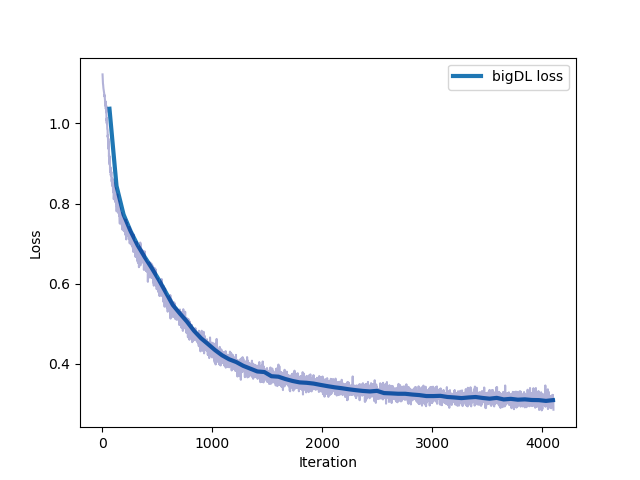

In [28]:
%matplotlib notebook
loss = np.array(train_summary.read_scalar("Loss"))

iteration = []
avg_loss = []
batch_loss = 0

for it, l in enumerate(loss[:,1]):
    batch_loss += l
    if (it%batch_size==0) and (it>0):
        avg_loss.append(batch_loss/batch_size)
        iteration.append(it)
        batch_loss = 0

plt.figure()
plt.plot(iteration, avg_loss, lw=3, label='bigDL loss')
plt.plot(loss[:,0], loss[:,1], alpha=0.3, color='navy')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


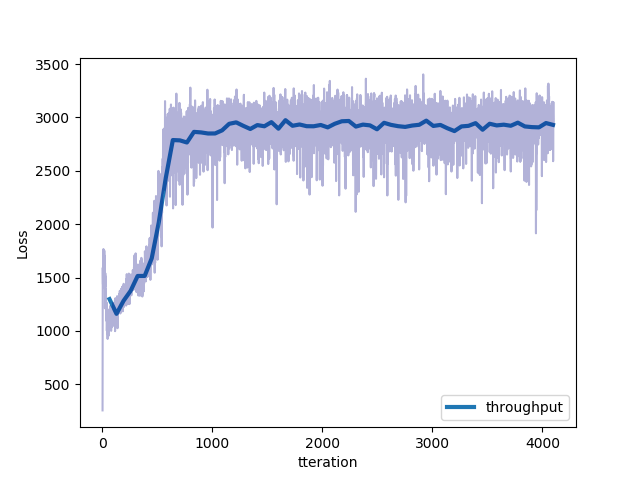

In [29]:
%matplotlib notebook
throughput = np.array(train_summary.read_scalar("Throughput"))

iteration = []
avg_throughput = []
batch_throughput = 0

for it, l in enumerate(throughput[:,1]):
    batch_throughput += l
    if (it%batch_size==0) and (it>0):
        avg_throughput.append(batch_throughput/batch_size)
        iteration.append(it)
        batch_throughput = 0

plt.figure()
plt.plot(iteration, avg_throughput, lw=3, label='throughput')
plt.plot(throughput[:,0], throughput[:,1], alpha=0.3, color='navy')
plt.xlabel('tteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Compute predictions

In [30]:
pred = trained_model.predict(testRDD)

In [31]:
pred.take(5)

[array([0.9858549 , 0.0107917 , 0.00335335], dtype=float32),
 array([0.98329115, 0.00832484, 0.00838408], dtype=float32),
 array([0.9956456 , 0.0013661 , 0.00298823], dtype=float32),
 array([0.0060668 , 0.97852325, 0.01540991], dtype=float32),
 array([1.4489759e-03, 9.9781644e-01, 7.3467160e-04], dtype=float32)]

In [32]:
testDF.select("label").take(5)

[Row(label=0), Row(label=0), Row(label=0), Row(label=1), Row(label=1)]

In [33]:
testRDD.map(lambda sampleTensor: sampleTensor.label.storage).take(3)

[array([2., 1., 1.], dtype=float32),
 array([2., 1., 1.], dtype=float32),
 array([2., 1., 1.], dtype=float32)]

## Plot ROC curve

In [34]:
%%time
y_pred = np.asarray(pred.collect())
y_true = np.asarray(testRDD.map(lambda sampleTensor: \
                                sampleTensor.label.storage).collect())

CPU times: user 429 ms, sys: 103 ms, total: 532 ms
Wall time: 2min 42s


In [35]:
y_true = np.asarray(testDF.rdd.map(lambda row: \
                                row.encoded_label).collect())

In [36]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


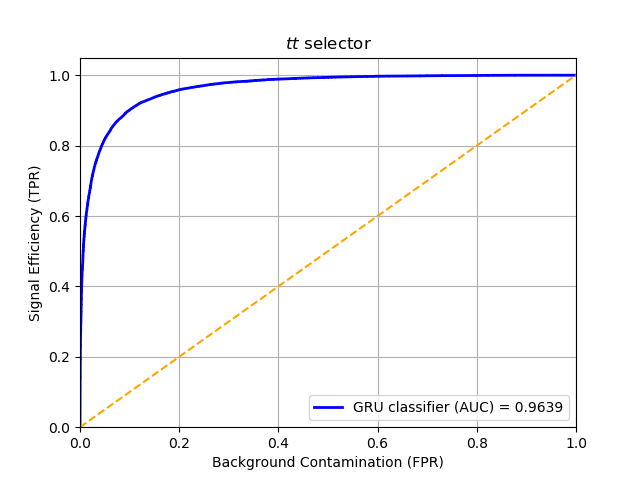

In [37]:
plt.figure()
plt.plot(fpr[0], tpr[0], color='blue',
         lw=2, label='GRU classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Plot Confusion Matrix

In [39]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.8829


<IPython.core.display.Javascript object>


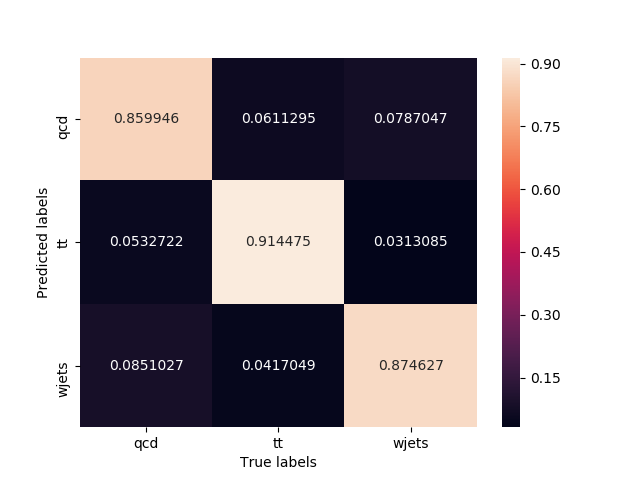

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Save and Load the model

In [31]:
model.saveModel(modelPath="GRUmodel_bigDL/model.bigdl",
                weightPath="GRUmodel_bigDL/model.bin",
                over_write=True)

In [32]:
from bigdl.nn.layer import Model

loaded = Model.loadModel("GRUmodel_bigDL/model.bigdl", "GRUmodel_bigDL/model.bin")

In [35]:
loaded.predict(testRDD).take(5)

[array([0.17004964, 0.8282393 , 0.0017111 ], dtype=float32),
 array([0.92571926, 0.03729377, 0.03698691], dtype=float32),
 array([1.7001661e-02, 1.8670292e-04, 9.8281163e-01], dtype=float32),
 array([0.50880796, 0.00185751, 0.4893346 ], dtype=float32),
 array([1.7099366e-02, 8.1309624e-04, 9.8208755e-01], dtype=float32)]